<a href="https://colab.research.google.com/github/sominshim/Predicting_Personality_through_Text/blob/main/Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
# !pip install tensorflow-hub
# !pip install tfds-nightly
import tensorflow_hub as hub
import tensorflow_datasets as tfds

print("버전: ", tf.__version__)
print("즉시 실행 모드: ", tf.executing_eagerly())
print("허브 버전: ", hub.__version__)
print("GPU", "사용 가능" if tf.config.experimental.list_physical_devices("GPU") else "사용 불가능")

버전:  2.3.0
즉시 실행 모드:  True
허브 버전:  0.10.0
GPU 사용 가능


In [2]:
# import module
import io
import pandas as pd

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline

np.random.seed(42)

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn import model_selection
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [4]:
# import math
# from tensorflow.python.keras import models
# from tensorflow.python.keras import initializers
# from tensorflow.python.keras import regularizers

# from tensorflow.python.keras.layers import Dense
# from tensorflow.python.keras.layers import Dropout
# from tensorflow.python.keras.layers import Embedding
# from tensorflow.python.keras.layers import SeparableConv1D
# from tensorflow.python.keras.layers import MaxPooling1D
# from tensorflow.python.keras.layers import GlobalAveragePooling1D

In [5]:
#드라이브에 접근할 수 있도록 아래 코드 입력
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#불러올 파일의 경로를 filename 변수에 저장
filename = '/content/drive/My Drive/mbti_1.csv'

In [7]:
#pandas read_csv로 불러오기
data = pd.read_csv(filename)
data.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [8]:
# Split mbti personality into 4 letters and binarize
titles = ["Extraversion (E) - Introversion (I)",
          "Sensation (S) - INtuition (N)",
          "Thinking (T) - Feeling (F)",
          "Judgement (J) - Perception (P)"
         ] 
b_Pers = {'I':0, 'E':1, 'N':0, 'S':1, 'F':0, 'T':1, 'J':0, 'P':1}
b_Pers_list = [{0:'I', 1:'E'}, {0:'N', 1:'S'}, {0:'F', 1:'T'}, {0:'J', 1:'P'}]


#transform mbti to binary vector
def translate_personality(personality):
    return [b_Pers[l] for l in personality]

#transform binary vector to mbti personality
def translate_back(personality):
    s = ""
    for i, l in enumerate(personality):
        s += b_Pers_list[i][l]
    return s

list_personality_bin = np.array([translate_personality(p) for p in data.type])
print("Binarize MBTI list: \n%s" % list_personality_bin)

Binarize MBTI list: 
[[0 0 0 0]
 [1 0 1 1]
 [0 0 1 1]
 ...
 [0 0 1 1]
 [0 0 0 1]
 [0 0 0 1]]


In [9]:
data['I-E'] = list_personality_bin[:,0]
data['N-S'] = list_personality_bin[:,1]
data['F-T'] = list_personality_bin[:,2]
data['J-P'] = list_personality_bin[:,3]

In [10]:
data.head()

,type,posts,I-E,N-S,F-T,J-P
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,0,0,0,0
1,ENTP,'I'm finding the lack of me in these posts ver...,1,0,1,1
2,INTP,'Good one _____ https://www.youtube.com/wat...,0,0,1,1
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",0,0,1,0
4,ENTJ,'You're fired.|||That's another silly misconce...,1,0,1,0


In [11]:
data['posts'][:5]

0    'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1    'I'm finding the lack of me in these posts ver...
2    'Good one  _____   https://www.youtube.com/wat...
3    'Dear INTP,   I enjoyed our conversation the o...
4    'You're fired.|||That's another silly misconce...
Name: posts, dtype: object

## 데이터 전처리

In [12]:
from sklearn.preprocessing import LabelBinarizer
import re
import string

In [13]:
contraction_patterns = [ (r'won\'t', 'will not'), (r'can\'t', 'cannot'), (r'I\'m', 'I am'),(r'i\'m', 'i am'), (r'ain\'t', 'is not'), (r'(\w+)\'ll', '\g<1> will'), (r'(\w+)n\'t', '\g<1> not'),
                         (r'(\w+)\'ve', '\g<1> have'), (r'(\w+)\'s', '\g<1> is'), (r'(\w+)\'re', '\g<1> are'), (r'(\w+)\'d', '\g<1> would'), (r'&', 'and'), (r'dammit', 'damn it'), (r'dont', 'do not'), (r'wont', 'will not') ]
def replace(text):
    patterns = [(re.compile(regex), repl) for (regex, repl) in contraction_patterns]
    for (pattern, repl) in patterns:
        (text, count) = re.subn(pattern, repl, text)
    return text

text_replace = pd.DataFrame(columns=['TextBefore', 'TextAfter'])
text_replace['TextBefore'] = data['posts'].copy()

In [14]:
for index, row in text_replace.iterrows():
    row['TextAfter'] = replace(row['TextBefore'])

In [15]:
print(text_replace['TextBefore'][:5],'\n->\n', text_replace['TextAfter'][:5])

0    'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1    'I'm finding the lack of me in these posts ver...
2    'Good one  _____   https://www.youtube.com/wat...
3    'Dear INTP,   I enjoyed our conversation the o...
4    'You're fired.|||That's another silly misconce...
Name: TextBefore, dtype: object 
->
 0    'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1    'I am finding the lack of me in these posts ve...
2    'Good one  _____   https://www.youtube.com/wat...
3    'Dear INTP,   I enjoyed our conversation the o...
4    'You are fired.|||That is another silly miscon...
Name: TextAfter, dtype: object


### 특수문자 제거

In [16]:
def cleaner(post):
    # 소문자 변환
    post = post.lower() 
    
    # '|||' 제거
    post = post.replace('|||', "") 

    # URL, 링크 등 특수문자 제거
    post = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', '', post, flags=re.MULTILINE) 

    # 구두점 제거
    post = post.translate(str.maketrans('', '', string.punctuation))

    # 공백 제거
    post = re.sub( '\s+', ' ', post ).strip()

    # MBTI 제거
    post = re.sub('infj|entp|intp|intj|entj|enfj|infp|enfp|isfp|istp|isfj|istj|estp|esfp|estj|esfj',"", post)

    # 길이가 짧은 단어 제거
    shortword = re.compile(r'\W*\b\w{1,2}\b')
    post = shortword.sub('', post)
    
    return post

In [17]:
posts = text_replace.TextAfter.tolist()
posts = [cleaner(post) for post in posts]
data['clean_post'] = posts

In [18]:
print(text_replace['TextAfter'][:5],'\n->\n', data['clean_post'][:5])

0    'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1    'I am finding the lack of me in these posts ve...
2    'Good one  _____   https://www.youtube.com/wat...
3    'Dear INTP,   I enjoyed our conversation the o...
4    'You are fired.|||That is another silly miscon...
Name: TextAfter, dtype: object 
->
 0    and  moments sportscenter not top ten plays pr...
1     finding the lack these posts very alarmingsex...
2    good one course which say know that blessing a...
3    dear enjoyed our conversation the other day es...
4    you are firedthat another silly misconception ...
Name: clean_post, dtype: object


### Remove Stopwords


In [19]:
# Remove Stopwords
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
stoplist = stopwords.words('english')

from nltk.stem import WordNetLemmatizer, PorterStemmer

n=WordNetLemmatizer()
s = PorterStemmer()

def tokenize(text):
    finalTokens = []
    tokens = nltk.word_tokenize(text)
    for w in tokens:
        if (w not in stoplist):
            finalTokens.append(w)
    lem  = [n.lemmatize(w) for w in finalTokens]
    stem = [s.stem(w) for w in lem]
    text = " ".join(stem)

    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [20]:
text_removeStopwords = pd.DataFrame(columns=['TextBefore', 'TextAfter'])
text_removeStopwords['TextBefore'] = data['clean_post'].copy()

In [21]:
nltk.download('punkt')
for index, row in text_removeStopwords.iterrows():
    row['TextAfter'] = tokenize(row['TextBefore'])

data['clean_post'] = text_removeStopwords['TextAfter']
print(data['clean_post'][:5],'\n->\n',text_removeStopwords['TextAfter'][:5])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
0    moment sportscent top ten play prankswhat life...
1    find lack post alarmingsex bore posit often ex...
2    good one cours say know bless cursedo absolut ...
3    dear enjoy convers day esoter gab natur univer...
4    firedthat anoth silli misconcept approach logi...
Name: clean_post, dtype: object 
->
 0    moment sportscent top ten play prankswhat life...
1    find lack post alarmingsex bore posit often ex...
2    good one cours say know bless cursedo absolut ...
3    dear enjoy convers day esoter gab natur univer...
4    firedthat anoth silli misconcept approach logi...
Name: TextAfter, dtype: object


### Most frequent mispells -> Correct manually 



In [22]:
mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum', 'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization', 'pokémon': 'pokemon'}
def correct_spelling(x, dic):
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x

In [23]:
data['clean_post'] = data['clean_post'].apply(lambda x: correct_spelling(x, mispell_dict))
data['clean_post'][:5]

0    moment sportscent top ten play prankswhat life...
1    find lack post alarmingsex bore posit often ex...
2    good one cours say know bless cursedo absolut ...
3    dear enjoy convers day esoter gab natur univer...
4    firedthat anoth silli misconcept approach logi...
Name: clean_post, dtype: object

In [24]:
sentences = data['clean_post']
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

In [25]:
encoded = tokenizer.texts_to_sequences(sentences)
print(encoded)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [26]:
max_len = max(len(item) for item in encoded)
print(max_len)

873


## Train/ Test/ Validation data Split

In [31]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data[['type']]):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]

X_train = strat_train_set.clean_post
X_test = strat_test_set.clean_post

print(X_train.shape)
print(X_test.shape)

(6940,)
(1735,)


In [33]:
print(f"X_train {len(X_train)}")
print("y_train", len(y_train))
print("X_test", len(X_test))
print("y_test", len(y_test))

X_train 6940
y_train 6940
X_test 1735
y_test 1735


In [34]:
X_train[:5]

1228    mandarin speaker receiv educ canada sinc 13tha...
1290    nope ever busi work caus adrenalinerush activ ...
6756    one gotten read yet might pick one bookstoreso...
1662    use think matur burn bridg without second thou...
3338    get type 4w5 5w6 well like consid 4w5 fit perf...
Name: clean_post, dtype: object

In [35]:
categories = ['I-E', 'N-S', 'F-T', 'J-P']

train, test = train_test_split(data, random_state=42, test_size=0.2, shuffle=True)
X_train = train.clean_post
X_test = test.clean_post

print(X_train.shape)
print(X_test.shape)

(6940,)
(1735,)


성능측정 : 

균형 데이터 -> Accuracy
불균형 데이터 -> f1-score

In [36]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [37]:
train.head()

,type,posts,I-E,N-S,F-T,J-P,clean_post
4080,INFJ,'I loved All the Light We Cannot See by Anthon...,0,0,0,0,love light see anthoni doerr pretti recent boo...
2614,ENFP,"'It depends. If I care about it, I fight and g...",1,0,0,1,depend care fight get realli aggress thing way...
5414,ENTP,"'Welcome home, sonny :laughing:|||Just because...",1,0,1,1,welcom home sonni laughingjust strong tendenc ...
1039,ENFP,That's really cool of you. I like it when anyo...,1,0,0,1,realli cool like anyon anyth help other gain r...
8294,ENTP,'The duck is named Zeus.|||http://www.youtube....,1,0,1,1,duck name zeu see trait mammalian predat human...


... Processing I-E
Test accuracy is 0.7798270893371758
[[1353    0]
 [ 382    0]]
              precision    recall  f1-score   support

           0       0.78      1.00      0.88      1353
           1       0.00      0.00      0.00       382

    accuracy                           0.78      1735
   macro avg       0.39      0.50      0.44      1735
weighted avg       0.61      0.78      0.68      1735



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50948 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50577 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49457 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47456 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/

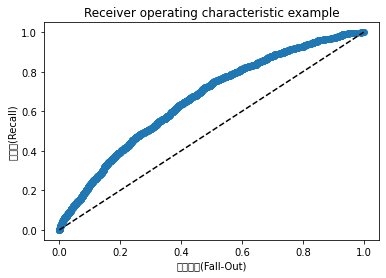

... Processing N-S
Test accuracy is 0.8582132564841498
[[1489    0]
 [ 246    0]]
              precision    recall  f1-score   support

           0       0.86      1.00      0.92      1489
           1       0.00      0.00      0.00       246

    accuracy                           0.86      1735
   macro avg       0.43      0.50      0.46      1735
weighted avg       0.74      0.86      0.79      1735



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50948 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50577 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49457 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47456 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/

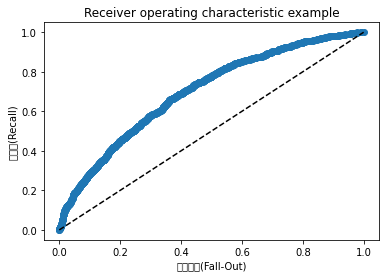

... Processing F-T
Test accuracy is 0.5913544668587897
[[907  30]
 [679 119]]
              precision    recall  f1-score   support

           0       0.57      0.97      0.72       937
           1       0.80      0.15      0.25       798

    accuracy                           0.59      1735
   macro avg       0.69      0.56      0.49      1735
weighted avg       0.68      0.59      0.50      1735



/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50948 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50577 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49457 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47456 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51116 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54788 missing from current font.
  font.set_

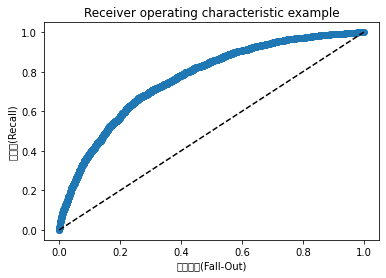

... Processing J-P
Test accuracy is 0.6144092219020173
[[   0  669]
 [   0 1066]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       669
           1       0.61      1.00      0.76      1066

    accuracy                           0.61      1735
   macro avg       0.31      0.50      0.38      1735
weighted avg       0.38      0.61      0.47      1735



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50948 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50577 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49457 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47456 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/

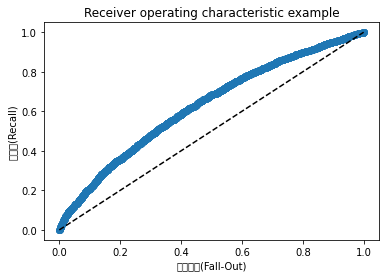

In [38]:
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(max_features=100)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])
for category in categories:
    print('... Processing {}'.format(category))
    # X_train_over, y_train_over = smote.fit_sample(X_train, train[category])
    NB_pipeline.fit(X_train, train[category])
    prediction = NB_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))
    print(confusion_matrix(test[category], prediction))
    # print(f1_score(test[category], prediction))
    print(classification_report(test[category], prediction, target_names=['0', '1']))

    from sklearn.metrics import roc_curve
    # test[category], prediction /X_train, train[category]
    fpr, tpr, thresholds = roc_curve(train[category], NB_pipeline.predict_proba(X_train)[:, 1])
    plt.plot(fpr, tpr, 'o-', label="Logistic Regression")
    plt.plot([0, 1], [0, 1], 'k--', label="random guess")
    # plt.plot([fallout], [recall], 'ro', ms=10)
    plt.xlabel('위양성률(Fall-Out)')
    plt.ylabel('재현률(Recall)')
    plt.title('Receiver operating characteristic example')
    plt.show()

... Processing I-E
Test accuracy is 0.7861671469740634
[[1266   87]
 [ 284   98]]
              precision    recall  f1-score   support

           0       0.82      0.94      0.87      1353
           1       0.53      0.26      0.35       382

    accuracy                           0.79      1735
   macro avg       0.67      0.60      0.61      1735
weighted avg       0.75      0.79      0.76      1735



/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50948 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50577 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49457 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47456 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51116 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54788 missing from current font.
  font.set_

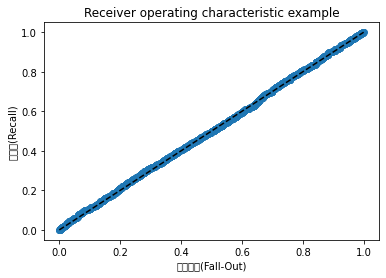

... Processing N-S
Test accuracy is 0.8622478386167147
[[1484    5]
 [ 234   12]]
              precision    recall  f1-score   support

           0       0.86      1.00      0.93      1489
           1       0.71      0.05      0.09       246

    accuracy                           0.86      1735
   macro avg       0.78      0.52      0.51      1735
weighted avg       0.84      0.86      0.81      1735



/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50948 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50577 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49457 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47456 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51116 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54788 missing from current font.
  font.set_

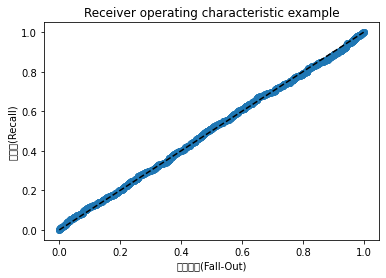

... Processing F-T
Test accuracy is 0.7878962536023055
[[777 160]
 [208 590]]
              precision    recall  f1-score   support

           0       0.79      0.83      0.81       937
           1       0.79      0.74      0.76       798

    accuracy                           0.79      1735
   macro avg       0.79      0.78      0.79      1735
weighted avg       0.79      0.79      0.79      1735



/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50948 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50577 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49457 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47456 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51116 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54788 missing from current font.
  font.set_

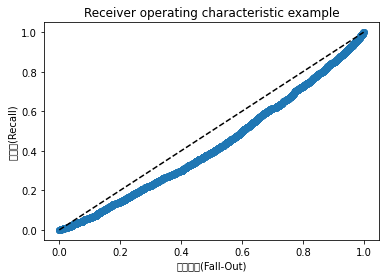

... Processing J-P
Test accuracy is 0.661671469740634
[[346 323]
 [264 802]]
              precision    recall  f1-score   support

           0       0.57      0.52      0.54       669
           1       0.71      0.75      0.73      1066

    accuracy                           0.66      1735
   macro avg       0.64      0.63      0.64      1735
weighted avg       0.66      0.66      0.66      1735



/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50948 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50577 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49457 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47456 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51116 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54788 missing from current font.
  font.set_

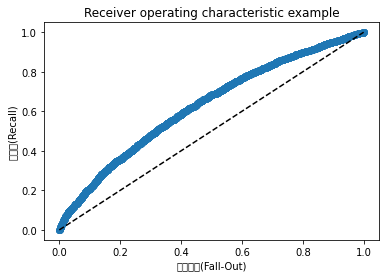

In [39]:
SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1))
])
for category in categories:
    print('... Processing {}'.format(category))
    SVC_pipeline.fit(X_train, train[category])
    prediction = SVC_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))
    print(confusion_matrix(test[category], prediction))
    # print(f1_score(test[category], prediction))
    print(classification_report(test[category], prediction, target_names=['0', '1']))
    from sklearn.metrics import roc_curve
    # test[category], prediction /X_train, train[category]
    fpr, tpr, thresholds = roc_curve(train[category], NB_pipeline.predict_proba(X_train)[:, 1])
    plt.plot(fpr, tpr, 'o-', label="Logistic Regression")
    plt.plot([0, 1], [0, 1], 'k--', label="random guess")
    # plt.plot([fallout], [recall], 'ro', ms=10)
    plt.xlabel('위양성률(Fall-Out)')
    plt.ylabel('재현률(Recall)')
    plt.title('Receiver operating characteristic example')
    plt.show()

... Processing I-E
Test accuracy is 0.7780979827089337
[[1326   27]
 [ 358   24]]
              precision    recall  f1-score   support

           0       0.79      0.98      0.87      1353
           1       0.47      0.06      0.11       382

    accuracy                           0.78      1735
   macro avg       0.63      0.52      0.49      1735
weighted avg       0.72      0.78      0.71      1735



/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50948 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50577 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49457 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47456 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51116 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54788 missing from current font.
  font.set_

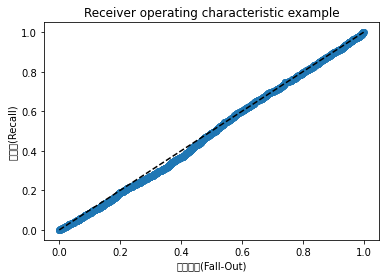

... Processing N-S
Test accuracy is 0.8570605187319885
[[1486    3]
 [ 245    1]]
              precision    recall  f1-score   support

           0       0.86      1.00      0.92      1489
           1       0.25      0.00      0.01       246

    accuracy                           0.86      1735
   macro avg       0.55      0.50      0.47      1735
weighted avg       0.77      0.86      0.79      1735



/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50948 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50577 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49457 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47456 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51116 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54788 missing from current font.
  font.set_

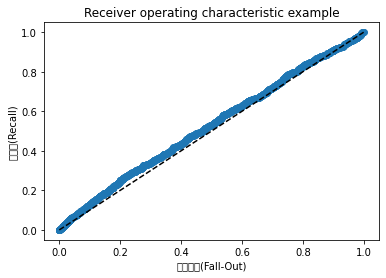

... Processing F-T
Test accuracy is 0.7170028818443804
[[709 228]
 [263 535]]
              precision    recall  f1-score   support

           0       0.73      0.76      0.74       937
           1       0.70      0.67      0.69       798

    accuracy                           0.72      1735
   macro avg       0.72      0.71      0.71      1735
weighted avg       0.72      0.72      0.72      1735



/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50948 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50577 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49457 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47456 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51116 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54788 missing from current font.
  font.set_

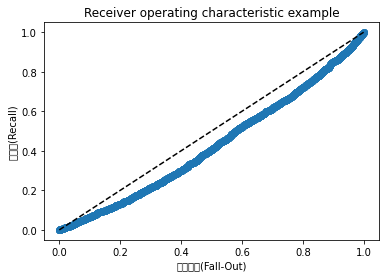

... Processing J-P
Test accuracy is 0.6236311239193083
[[192 477]
 [176 890]]
              precision    recall  f1-score   support

           0       0.52      0.29      0.37       669
           1       0.65      0.83      0.73      1066

    accuracy                           0.62      1735
   macro avg       0.59      0.56      0.55      1735
weighted avg       0.60      0.62      0.59      1735



/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50948 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50577 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49457 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47456 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51116 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54788 missing from current font.
  font.set_

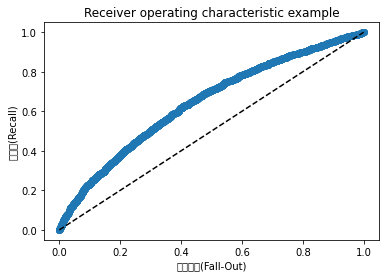

In [55]:
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(max_features=200)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])
for category in categories:
    print('... Processing {}'.format(category))
    LogReg_pipeline.fit(X_train, train[category])
    prediction = LogReg_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))
    print(confusion_matrix(test[category], prediction))
    # print(f1_score(test[category], prediction))
    print(classification_report(test[category], prediction, target_names=['0', '1']))
    from sklearn.metrics import roc_curve
    # test[category], prediction /X_train, train[category]
    fpr, tpr, thresholds = roc_curve(train[category], NB_pipeline.predict_proba(X_train)[:, 1])
    plt.plot(fpr, tpr, 'o-', label="Logistic Regression")
    plt.plot([0, 1], [0, 1], 'k--', label="random guess")
    # plt.plot([fallout], [recall], 'ro', ms=10)
    plt.xlabel('위양성률(Fall-Out)')
    plt.ylabel('재현률(Recall)')
    plt.title('Receiver operating characteristic example')
    plt.show()

In [69]:
somin_text=[" I am studying computer programming and statistics at Sejong University to become a big data analyst (data scientist). Since the department was newly established in 2017, there is no established curriculum and there is no seniors. In addition, there are many times when we do not know how to study. However, during my three semesters I had a certain sense of enlightenment. I want to become as data scientist by studying my magor and I have to be proficient in English to achieve my dream. When I attended a seminar at NC-soft Company, I wanted to work in a foreign country. I have heard that Korea's data scientists do not have their own roles and are doing various things in various fields. It is because big data field did not develop in Korea. And beacause of the ‘protection law’ on personal information leakage, I think that this field will not grow under the policy of Korea, which can not even collect data, which is the most basic step of data analysis. So I decided to go abroad to become a real data scientist. I also made the same commitment when I took an introduction to data analysis in English. When I did not know the concept, I studied with internet search, and all the materials and Youtube lectures were in English. So I had difficulty taking this course. Through this, I once again felt the need for English. I spent two years studying at school and thought that English should be the foundation for me to learn my major deeply and surely. So I decided that I would become more familiar with English through exchange students and would be very helpful for future foreign entry. There are two reasons to go to the The Hague University of Applied Sciences in the Netherlands through the exchange student program. One of that the English level of the European countries 2-3 ranking well. Statistically, Dutch people overestimate their English skills. They have a high level of confidence in English and think that I can not speak English perfectly because I am a foreigner. It is the opposite of Korea, which it is better not to say it because of poor pronunciation or lack of confidence in English ability. In this free environment, I want to assimilate with the Dutch and increase my confidence in English. The other reason is that there is a curriculum that allows students to experience their majors in practice. Taking the APPLIED DATA SCIENCE HBO-ICT course at The Hague University, a team of 6-8 students and an experienced data scientist conducts a project on data science research for half the semester. The other half is about learning about data science, machine learning, Python laptops, and so on. This curriculum has become very attractive. The job of DataScientist is promising, but I always wondered what it does in practice because of lack of relevant information and history. However, if I complete the APPLIED DATA SCIENCE HBO-ICT curriculum, which can not be done at Sejong University, I can solve my questions and dreams will become concrete. For this reason, I would like to be selected for the exchange student program at the The Hague University of Applied Sciences in the Netherlands and to be proud of the school."]

In [ ]:
for category in categories:
    print('... Processing {}'.format(category))
    # X_train_over, y_train_over = smote.fit_sample(X_train, train[category])
    NB_pipeline.fit(X_train, train[category])
    prediction = NB_pipeline.predict(X_test)